# Lets treat this dataframe as if it is a very large file and segment into chunks of 10000 lines

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torchtext.data.utils import get_tokenizer
from collections import Counter
from torchtext.vocab import Vocab
from tqdm import tqdm

In [2]:
%%time
chonky = 10000
ntrain = 0
nvalid = 0
ntest = 0
max_length = 0
average_upvotes = 0

modes = ['train','valid','test']

for m in modes:
    csvfile = '/home/dominique/Projects/eluvio/' + m + '.csv'
    for num,chunk in enumerate(pd.read_csv(csvfile,chunksize=chonky)):
        filename = m + '_chunks/chunk'+str(num)+'.csv'
        if m == 'train':
            ntrain += len(chunk)
        elif m == 'valid':
            nvalid += len(chunk)
        else:
            ntest += len(chunk)
        chunk.to_csv(filename)

CPU times: user 2.19 s, sys: 59.9 ms, total: 2.25 s
Wall time: 2.25 s


# Define dataset to load from our chunks as needed

In [3]:
class TitlesDataset(torch.utils.data.Dataset):
    def __init__(self,mode='train'):
        self.mode = mode
        self.filename = None
        self.df = None
    
    def __getitem__(self, idx):
        cfilename = self.mode + '_chunks/chunk' + str(idx//chonky) + '.csv'
        
# check if we need to load a new chunck
        if self.filename != cfilename:
            self.filename = cfilename
            self.df = pd.read_csv(cfilename)
        
        ind = idx%chonky

        title = self.df.title.iloc[ind]
        votes = self.df.up_votes.iloc[ind]
        return votes,title
        
    def __len__(self):
        if self.mode == 'train':
            return ntrain
        elif self.mode == 'valid':
            return nvalid
        else:
            return ntest

# Use the torchtext tokenizer for the titles

In [4]:
%%time
tokenizer = get_tokenizer('basic_english')
train_iter = TitlesDataset()
counter = Counter()
for (votes, line) in train_iter:
    counter.update(tokenizer(line))
vocab = Vocab(counter, min_freq=1)

CPU times: user 11.2 s, sys: 55.8 ms, total: 11.2 s
Wall time: 11.2 s


# Define pipline for title tokenization

In [5]:
text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

# Define pipline for label based off of the two classes in the training set

In [7]:
label_pipeline = lambda x: 1 if x >= 5 else 0

# Define collate function and create data loaders

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

trainloader = torch.utils.data.DataLoader(train_iter, batch_size=512, shuffle=False, collate_fn=collate_batch)
valid_iter = TitlesDataset(mode='valid')
validloader = torch.utils.data.DataLoader(valid_iter, batch_size=512, shuffle=False, collate_fn=collate_batch)

# Define our classification model

In [9]:
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim,dense_dim, ndense, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.embed2dense = nn.Sequential(nn.Linear(embed_dim, dense_dim),
                                  nn.ReLU(),
                                  nn.BatchNorm1d(dense_dim))
        
        self.denselist = []

        for i in range(ndense):
            self.denselist.append(nn.Sequential(nn.Linear(dense_dim, dense_dim),
                                  nn.ReLU(),
                                  nn.BatchNorm1d(dense_dim)))

        self.denselist = nn.ModuleList(self.denselist)

        self.denseout = nn.Sequential(
            nn.Linear(dense_dim, num_class),
            nn.Softmax()
        )


    def forward(self, text, offsets):
        x = self.embedding(text, offsets)
        x = self.embed2dense(x)
        identity = x
        for layer in self.denselist:
            x = layer(x)
        x = x + identity
        x = self.denseout(x)
        return x

# Define train function

In [10]:
def train(model, trainloader, validloader, NUM_EPOCHS):
    train_loss = []
    valid_loss = []
    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss = 0.0
        for data in trainloader:
            votes,title,offsets = data
            

            votes = votes.to(device)
            title = title.to(device)
            offsets = offsets.to(device)

            optimizer.zero_grad()

            pred = model(title,offsets)  
            loss = criterion(pred, votes)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
        loss = running_loss / len(trainloader)
        train_loss.append(loss)
        
        
        model.eval()
        running_loss = 0.0

        with torch.no_grad():
            for data in validloader:
                votes,title,offsets = data
                pred = model(title, offsets)
                loss = criterion(pred, votes)
                running_loss += loss.item()

        loss = running_loss / len(validloader)           
        valid_loss.append(loss)
        
        print('-' * 50)
        print('| epoch {:3d} | valid loss {:8.3f} | train loss {:8.3f} |'.format(epoch, valid_loss[-1], train_loss[-1]))
        print('-' * 50)    

        if valid_loss[-1] == min(valid_loss):
            PATH = "best_model.pt"
            torch.save(model.state_dict(), PATH) 
            
        if epoch % 5 == 0:
            scheduler.step()

    return valid_loss,train_loss

# Train model

In [11]:
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
vocab_size = len(vocab)
embed_size = 2048
dense_size = 512
ndense = 4

model = TextClassificationModel(vocab_size,embed_size,dense_size, ndense, 2)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.5)
model.to(device)

TextClassificationModel(
  (embedding): EmbeddingBag(120725, 2048, mode=mean)
  (embed2dense): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (denselist): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
      (1): ReLU()
      (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=512, bias=True)
     

In [12]:
valid_loss,train_loss = train(model, trainloader, validloader, NUM_EPOCHS)

/home/dominique/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


--------------------------------------------------
| epoch   0 | valid loss    0.692 | train loss    0.698 |
--------------------------------------------------
--------------------------------------------------
| epoch   1 | valid loss    0.690 | train loss    0.690 |
--------------------------------------------------
--------------------------------------------------
| epoch   2 | valid loss    0.688 | train loss    0.687 |
--------------------------------------------------
--------------------------------------------------
| epoch   3 | valid loss    0.687 | train loss    0.685 |
--------------------------------------------------
--------------------------------------------------
| epoch   4 | valid loss    0.686 | train loss    0.683 |
--------------------------------------------------
--------------------------------------------------
| epoch   5 | valid loss    0.685 | train loss    0.681 |
--------------------------------------------------
----------------------------------------

In [13]:
model.load_state_dict(torch.load('/home/dominique/Projects/eluvio/best_model.pt'))

<All keys matched successfully>

In [14]:
def predict(text, text_pipeline, model):
    model.eval()
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text), dtype=torch.int64)
        text = text.to(device)
        offset = torch.tensor([0], dtype=torch.int64)
        offset = offset.to(device)
        output = model(text, offset)
        return output.argmax(1).item()

In [25]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# Let's see how our model peforms on our test set

In [29]:
group = []
pred_group = []

for j in range(5):
    chunkfile = '/home/dominique/Projects/eluvio/test_chunks/chunk' + str(j) + '.csv'
    chunk = pd.read_csv(chunkfile)
    for i in range(len(chunk)):
        group.append(label_pipeline(chunk.at[i,'up_votes']))
        pred_group.append(predict(chunk.at[i,'title'], text_pipeline, model))

/home/dominique/anaconda3/lib/python3.8/site-packages/torch/nn/modules/container.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


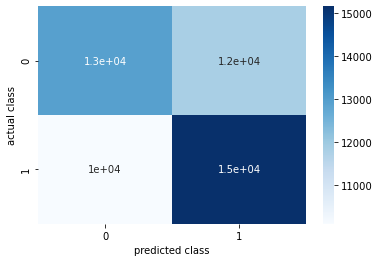

In [33]:
cf_matrix = confusion_matrix(group,pred_group)
sns_plot = sns.heatmap(cf_matrix, annot=True, cmap='Blues')
plt.xlabel("predicted class")
plt.ylabel("actual class")
fig = sns_plot.get_figure()
fig.savefig("confusion_mat.png")
plt.show()

# Let's look at some NYTimes article titles from the World News section

In [20]:
NYTimes_titles = []
NYTimes_titles.append('Exit Date Is 20 Years After Attacks That Spurred Longest U.S. War')
NYTimes_titles.append('Darius, ‘World’s Longest Rabbit,’ Is Missing')
NYTimes_titles.append('Graduation ceremonies will be allowed in New York this spring, with restrictions.')
NYTimes_titles.append('England reopens shops and some pubs and restaurants after three months of lockdown.')
NYTimes_titles.append('U.S. Signals Support for Ukraine and Will Add Troops in Germany')
NYTimes_titles.append('Taiwan Hunters Contend With Taboos, and Trials, to Uphold Tradition')
NYTimes_titles.append('Where Boars Hog the Streets')
NYTimes_titles.append('The N.F.L. will restrict unvaccinated coaches and staff from working with players.')
NYTimes_titles.append('French Wine Production Ravaged by a Devastating Frost')

In [21]:
for titles in NYTimes_titles:
    group = predict(titles, text_pipeline, model)
    print(titles,'is in the',group,'group\n')

Exit Date Is 20 Years After Attacks That Spurred Longest U.S. War is in the 1 group

Darius, ‘World’s Longest Rabbit,’ Is Missing is in the 0 group

Graduation ceremonies will be allowed in New York this spring, with restrictions. is in the 0 group

England reopens shops and some pubs and restaurants after three months of lockdown. is in the 1 group

U.S. Signals Support for Ukraine and Will Add Troops in Germany is in the 1 group

Taiwan Hunters Contend With Taboos, and Trials, to Uphold Tradition is in the 0 group

Where Boars Hog the Streets is in the 0 group

The N.F.L. will restrict unvaccinated coaches and staff from working with players. is in the 1 group

French Wine Production Ravaged by a Devastating Frost is in the 0 group

